<a href="https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [0]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.95.83.234:8470
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 2204676422108459207),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11313756108960186354),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17654255306167292778),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14351922719313144005),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4973633010266650051),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0

In [1]:
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import modeling
import optimization
import run_classifier
import run_classifier_with_tfhub
import tokenization

# import tfhub 
import tensorflow_hub as hub

Cloning into 'bert_repo'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 283.40 KiB | 3.94 MiB/s, done.
Resolving deltas: 100% (185/185), done.



In [0]:
TASK = 'WikiQAv5.0'
BUCKET = 'bert-logs-zalo'
assert BUCKET, 'Must specify an existing GCS bucket name'
OUTPUT_DIR = 'gs://{}/bert-tfhub/models/{}'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))
BERT_MODEL = 'multi_cased_L-12_H-768_A-12' 
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'

***** Model output directory: gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0 *****


In [0]:
tokenizer = run_classifier_with_tfhub.create_tokenizer_from_hub_module(BERT_MODEL_HUB)
tokenizer.tokenize('Học máy ( tiếng Anh : " machine learning " ) là một lĩnh vực của trí tuệ nhân tạo')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


['Học',
 'máy',
 '(',
 'tiếng',
 'Anh',
 ':',
 '"',
 'machine',
 'learning',
 '"',
 ')',
 'là',
 'một',
 'lĩnh',
 'vực',
 'của',
 'trí',
 'tu',
 '##ệ',
 'nhân',
 'tạo']

## Data

In [0]:
from tensorflow import keras
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [0]:
def download(link, name):
  dataset = tf.keras.utils.get_file(
      fname=name+".zip", 
      origin=link, 
      extract=True)
  with tf.gfile.GFile(os.path.join(os.path.dirname(dataset), name+'.json'), "r") as f:
    data_dict = json.load(f)
    return data_dict

In [0]:
train_dict = download('https://dl.challenge.zalo.ai/ZAC2019_VietnameseWikiQA/train.zip','train')

2506752/2504567 [==============================] - 1s 0us/step


In [0]:
df = pd.DataFrame.from_dict(train_dict)

In [0]:
df['label']=np.where(df['label']==True,1,0)

In [0]:
train, dev = train_test_split(df, test_size=0.01,random_state=42)

In [0]:
train_InputExamples = train.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['question'], 
                                                                   text_b = x['text'], 
                                                                   label = x['label']), axis = 1)
dev_InputExamples = dev.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['question'], 
                                                                   text_b = x['text'], 
                                                                   label = x['label']), axis = 1)


In [0]:
label_list = [0, 1]

Also we initilize our hyperprams, prepare the training data and initialize TPU config.

In [0]:
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
MAX_SEQ_LENGTH = 256
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 1000

# Compute number of train and warmup steps from batch size
num_train_steps = int(len(train) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
ITERATIONS_PER_LOOP = 1000

def get_run_config(output_dir):
  return tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=output_dir,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))


# Fine-tune and Run Predictions on a pretrained BERT Model from TF Hub

This section demonstrates fine-tuning from a pre-trained BERT TF Hub module and running predictions.


In [0]:
def create_model(is_training, input_ids, input_mask, segment_ids, labels,
                 num_labels, bert_hub_module_handle):
  """Creates a classification model."""
  tags = set()
  if is_training:
    tags.add("train")
  bert_module = hub.Module(bert_hub_module_handle, tags=tags, trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # In the demo, we are doing a simple classification task on the entire
  # segment.
  #
  # If you want to use the token-level output, use
  # bert_outputs["sequence_output"] instead.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):
    if is_training:
      # I.e., 0.1 dropout
      output_layer = tf.nn.dropout(output_layer, keep_prob=0.5)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    probabilities = tf.nn.softmax(logits, axis=-1)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)

    return (loss, per_example_loss, logits, probabilities)

def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps, use_tpu, bert_hub_module_handle):
  """Returns `model_fn` closure for TPUEstimator."""

  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    tf.logging.info("*** Features ***")
    for name in sorted(features.keys()):
      tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    (total_loss, per_example_loss, logits, probabilities) = create_model(
        is_training, input_ids, input_mask, segment_ids, label_ids, num_labels,
        bert_hub_module_handle)

    output_spec = None

    if mode == tf.estimator.ModeKeys.TRAIN:

      train_op = optimization.create_optimizer(
          total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          train_op=train_op)
    elif mode == tf.estimator.ModeKeys.EVAL:

      def metric_fn(per_example_loss, label_ids, logits):
        predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
        accuracy = tf.metrics.accuracy(label_ids, predictions)
        loss = tf.metrics.mean(per_example_loss)
        f1_score = tf.contrib.metrics.f1_score(label_ids, predictions)
        return {
            "eval_accuracy": accuracy,
            "eval_loss": loss,
            "f1_score": f1_score
        }

      eval_metrics = (metric_fn, [per_example_loss, label_ids, logits])
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          eval_metrics=eval_metrics)
    elif mode == tf.estimator.ModeKeys.PREDICT:
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode, predictions={"probabilities": probabilities})
    else:
      raise ValueError(
          "Only TRAIN, EVAL and PREDICT modes are supported: %s" % (mode))

    return output_spec

  return model_fn


In [0]:
# Force TF Hub writes to the GS bucket we provide.
os.environ['TFHUB_CACHE_DIR'] = OUTPUT_DIR

model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=True,
  bert_hub_module_handle=BERT_MODEL_HUB
)

estimator_from_tfhub = tf.contrib.tpu.TPUEstimator(
  use_tpu=True,
  model_fn=model_fn,
  config=get_run_config(OUTPUT_DIR),
  train_batch_size=TRAIN_BATCH_SIZE,
  eval_batch_size=EVAL_BATCH_SIZE,
  predict_batch_size=PREDICT_BATCH_SIZE,
)

INFO:tensorflow:Using config: {'_model_dir': 'gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.95.83.234:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7536fce5c0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.95.83.234:8470', '_evaluation_master': 'grpc://10.95.83.234:8470', '_is_chief': True, 

INFO:tensorflow:Using config: {'_model_dir': 'gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.95.83.234:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7536fce5c0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.95.83.234:8470', '_evaluation_master': 'grpc://10.95.83.234:8470', '_is_chief': True, 

INFO:tensorflow:_TPUContext: eval_on_tpu True


INFO:tensorflow:_TPUContext: eval_on_tpu True


At this point, you can now fine-tune the model, evaluate it, and run predictions on it.

In [0]:
# Train the model
def model_train(estimator):
  # We'll set sequences to be at most 128 tokens long.
  train_features = run_classifier.convert_examples_to_features(
      train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started training at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(train)))
  print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
  tf.logging.info("  Num steps = %d", num_train_steps)
  train_input_fn = run_classifier.input_fn_builder(
      features=train_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=True,
      drop_remainder=True)
  estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
  print('***** Finished training at {} *****'.format(datetime.datetime.now()))



In [0]:
model_train(estimator_from_tfhub)

INFO:tensorflow:Writing example 0 of 17926


INFO:tensorflow:Writing example 0 of 17926


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] N ##ước nào ở khu vực Đông Nam Á không giáp với biển [SEP] Là ##o là nước độc lập không giáp biển nằm ở khu vực Đông Nam Á . Xu ##ng quanh là các nước Trung Quốc , Việt Nam , Camp ##uchi ##a , Thái Lan và My ##an ##ma . [SEP]


INFO:tensorflow:tokens: [CLS] N ##ước nào ở khu vực Đông Nam Á không giáp với biển [SEP] Là ##o là nước độc lập không giáp biển nằm ở khu vực Đông Nam Á . Xu ##ng quanh là các nước Trung Quốc , Việt Nam , Camp ##uchi ##a , Thái Lan và My ##an ##ma . [SEP]


INFO:tensorflow:input_ids: 101 151 76238 27258 1682 16028 18505 20053 12645 226 11755 29781 11182 18394 102 61767 10133 10331 12932 32163 15707 11755 29781 18394 21152 1682 16028 18505 20053 12645 226 119 52145 10376 46883 10331 10792 12932 14549 14755 117 14426 12645 117 20020 62922 10113 117 20985 19670 10432 11590 10206 10369 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 151 76238 27258 1682 16028 18505 20053 12645 226 11755 29781 11182 18394 102 61767 10133 10331 12932 32163 15707 11755 29781 18394 21152 1682 16028 18505 20053 12645 226 119 52145 10376 46883 10331 10792 12932 14549 14755 117 14426 12645 117 20020 62922 10113 117 20985 19670 10432 11590 10206 10369 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Đài Loan còn có tên gọi nào khác [SEP] Bản hướng dẫn ISO 3166 về tên gọi các quốc gia và vùng lãnh thổ cấp mã riêng biệt cho Đài Loan ( T ##W ) , ngoài mã của Cộng ho ##à Nhân dân Trung Hoa ( CN ) , nhưng liệt kê Đài Đ ##oan là " Đài Loan , tỉnh của Trung Quốc " dựa theo cái tên do Liên hiệp quốc sử dụng với sức é ##p từ phía Cộng ho ##à Nhân dân Trung Hoa . [SEP]


INFO:tensorflow:tokens: [CLS] Đài Loan còn có tên gọi nào khác [SEP] Bản hướng dẫn ISO 3166 về tên gọi các quốc gia và vùng lãnh thổ cấp mã riêng biệt cho Đài Loan ( T ##W ) , ngoài mã của Cộng ho ##à Nhân dân Trung Hoa ( CN ) , nhưng liệt kê Đài Đ ##oan là " Đài Loan , tỉnh của Trung Quốc " dựa theo cái tên do Liên hiệp quốc sử dụng với sức é ##p từ phía Cộng ho ##à Nhân dân Trung Hoa . [SEP]


INFO:tensorflow:input_ids: 101 49509 67387 14674 10601 15322 17430 27258 14393 102 24745 30096 26093 15859 48115 12420 15322 17430 10792 14369 13223 10432 15273 30608 50546 18928 63432 39778 21646 11257 49509 67387 113 157 13034 114 117 25331 63432 10447 26073 13173 10816 38748 12486 14549 15475 113 73067 114 117 15662 78384 78977 49509 298 28337 10331 107 49509 67387 117 14221 10447 14549 14755 107 47766 13951 28296 15322 10149 22447 66866 14369 14808 15237 11182 36600 263 10410 11840 15564 26073 13173 10816 38748 12486 14549 15475 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 49509 67387 14674 10601 15322 17430 27258 14393 102 24745 30096 26093 15859 48115 12420 15322 17430 10792 14369 13223 10432 15273 30608 50546 18928 63432 39778 21646 11257 49509 67387 113 157 13034 114 117 25331 63432 10447 26073 13173 10816 38748 12486 14549 15475 113 73067 114 117 15662 78384 78977 49509 298 28337 10331 107 49509 67387 117 14221 10447 14549 14755 107 47766 13951 28296 15322 10149 22447 66866 14369 14808 15237 11182 36600 263 10410 11840 15564 26073 13173 10816 38748 12486 14549 15475 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Đ ##ền Trần hiện nay được xây dựng vào giai đoạn lịch sử nào [SEP] Đ ##ền Trần được xây dựng từ năm 1695 [SEP]


INFO:tensorflow:tokens: [CLS] Đ ##ền Trần hiện nay được xây dựng vào giai đoạn lịch sử nào [SEP] Đ ##ền Trần được xây dựng từ năm 1695 [SEP]


INFO:tensorflow:input_ids: 101 298 28234 31177 13526 21537 10476 27465 26661 11603 45549 31709 26137 14808 27258 102 298 28234 31177 10476 27465 26661 11840 10558 42981 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 298 28234 31177 13526 21537 10476 27465 26661 11603 45549 31709 26137 14808 27258 102 298 28234 31177 10476 27465 26661 11840 10558 42981 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Nguyễn Th ##i ##ếp quê ở đ ##âu [SEP] Sau đại thắng vào đầu x ##u ##ân K ##ỷ D ##ậu ( 1789 ) , vua Quang Trung về đến Nghệ An lại mời Nguyễn Th ##i ##ếp đến bàn quốc sự . [SEP]


INFO:tensorflow:tokens: [CLS] Nguyễn Th ##i ##ếp quê ở đ ##âu [SEP] Sau đại thắng vào đầu x ##u ##ân K ##ỷ D ##ậu ( 1789 ) , vua Quang Trung về đến Nghệ An lại mời Nguyễn Th ##i ##ếp đến bàn quốc sự . [SEP]


INFO:tensorflow:input_ids: 101 21471 51635 10116 53378 86802 1682 299 28345 102 19076 16071 27368 11603 11201 192 10138 15218 148 49825 141 62496 113 17887 114 117 25400 48314 14549 12420 12002 83250 10313 13148 102668 21471 51635 10116 53378 12002 33899 14369 12636 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 21471 51635 10116 53378 86802 1682 299 28345 102 19076 16071 27368 11603 11201 192 10138 15218 148 49825 141 62496 113 17887 114 117 25400 48314 14549 12420 12002 83250 10313 13148 102668 21471 51635 10116 53378 12002 33899 14369 12636 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Hiện nay l ##ăng mộ thừa tướng L ##ữ Gia nằm ở đ ##âu [SEP] Hiện nay , l ##ăng mộ này nằm trên đường quốc lộ 1A , từ cầu Ch ##ánh Hòa ( thuộc huyện B ##ố T ##r ##ạch ) đi về phía Đông theo đường huyện lộ ch ##ừng 3 km , do bị xuống cấp bởi thời gian và chiến tranh , dòng họ Hồ ở Nhân T ##r ##ạch , B ##ố T ##r ##ạch đã chuyển phần mộ của ông về tại khu ##ôn viên l ##ăng mộ dòng họ Hồ ở Nhân T ##r ##ạch . [SEP]


INFO:tensorflow:tokens: [CLS] Hiện nay l ##ăng mộ thừa tướng L ##ữ Gia nằm ở đ ##âu [SEP] Hiện nay , l ##ăng mộ này nằm trên đường quốc lộ 1A , từ cầu Ch ##ánh Hòa ( thuộc huyện B ##ố T ##r ##ạch ) đi về phía Đông theo đường huyện lộ ch ##ừng 3 km , do bị xuống cấp bởi thời gian và chiến tranh , dòng họ Hồ ở Nhân T ##r ##ạch , B ##ố T ##r ##ạch đã chuyển phần mộ của ông về tại khu ##ôn viên l ##ăng mộ dòng họ Hồ ở Nhân T ##r ##ạch . [SEP]


INFO:tensorflow:input_ids: 101 77513 21537 180 26906 75755 69721 22313 149 59678 42106 21152 1682 299 28345 102 77513 21537 117 180 26906 75755 10789 21152 12598 17773 14369 43993 74903 117 11840 19168 33939 55064 33053 113 12005 15222 139 44315 157 10129 29372 114 16895 12420 15564 20053 13951 17773 15222 43993 18643 35791 124 10204 117 10149 12505 39246 18928 15686 13199 20264 10432 14463 19383 117 40563 10876 34052 1682 38748 157 10129 29372 117 139 44315 157 10129 29372 11213 20383 15958 75755 10447 12660 12420 12086 16028 37401 15202 180 26906 75755 40563 10876 34052 1682 38748 157 10129 29372 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 77513 21537 180 26906 75755 69721 22313 149 59678 42106 21152 1682 299 28345 102 77513 21537 117 180 26906 75755 10789 21152 12598 17773 14369 43993 74903 117 11840 19168 33939 55064 33053 113 12005 15222 139 44315 157 10129 29372 114 16895 12420 15564 20053 13951 17773 15222 43993 18643 35791 124 10204 117 10149 12505 39246 18928 15686 13199 20264 10432 14463 19383 117 40563 10876 34052 1682 38748 157 10129 29372 117 139 44315 157 10129 29372 11213 20383 15958 75755 10447 12660 12420 12086 16028 37401 15202 180 26906 75755 40563 10876 34052 1682 38748 157 10129 29372 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 17926


INFO:tensorflow:Writing example 10000 of 17926


***** Started training at 2019-11-25 18:06:20.895874 *****
  Num examples = 17926
  Batch size = 16
INFO:tensorflow:  Num steps = 3361


INFO:tensorflow:  Num steps = 3361


INFO:tensorflow:Querying Tensorflow master (grpc://10.95.83.234:8470) for TPU system metadata.


INFO:tensorflow:Querying Tensorflow master (grpc://10.95.83.234:8470) for TPU system metadata.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2204676422108459207)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2204676422108459207)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17654255306167292778)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17654255306167292778)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14351922719313144005)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14351922719313144005)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4973633010266650051)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 4973633010266650051)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 7073275947122365795)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 7073275947122365795)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 602665409412993700)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 602665409412993700)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 1008039598861276824)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 1008039598861276824)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 17388383968304458528)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 17388383968304458528)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 17868044357804238199)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 17868044357804238199)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 12669223275291908199)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 12669223275291908199)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11313756108960186354)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11313756108960186354)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (2, 256)


INFO:tensorflow:  name = input_ids, shape = (2, 256)


INFO:tensorflow:  name = input_mask, shape = (2, 256)


INFO:tensorflow:  name = input_mask, shape = (2, 256)


INFO:tensorflow:  name = label_ids, shape = (2,)


INFO:tensorflow:  name = label_ids, shape = (2,)


INFO:tensorflow:  name = segment_ids, shape = (2, 256)


INFO:tensorflow:  name = segment_ids, shape = (2, 256)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


INFO:tensorflow:Initialized dataset iterators in 1 seconds


INFO:tensorflow:Initialized dataset iterators in 1 seconds


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Saving checkpoints for 1000 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


INFO:tensorflow:loss = 0.0004958799, step = 1000


INFO:tensorflow:loss = 0.0004958799, step = 1000


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (1, 0)


INFO:tensorflow:Outfeed finished for iteration (1, 0)


INFO:tensorflow:Saving checkpoints for 2000 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


INFO:tensorflow:loss = 0.0074232714, step = 2000 (115.453 sec)


INFO:tensorflow:loss = 0.0074232714, step = 2000 (115.453 sec)


INFO:tensorflow:global_step/sec: 8.66108


INFO:tensorflow:global_step/sec: 8.66108


INFO:tensorflow:examples/sec: 138.577


INFO:tensorflow:examples/sec: 138.577


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (2, 0)


INFO:tensorflow:Outfeed finished for iteration (2, 0)


INFO:tensorflow:Saving checkpoints for 3000 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3000 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


INFO:tensorflow:loss = 0.00012520961, step = 3000 (118.041 sec)


INFO:tensorflow:loss = 0.00012520961, step = 3000 (118.041 sec)


INFO:tensorflow:global_step/sec: 8.47141


INFO:tensorflow:global_step/sec: 8.47141


INFO:tensorflow:examples/sec: 135.543


INFO:tensorflow:examples/sec: 135.543


INFO:tensorflow:Enqueue next (361) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (361) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (361) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (361) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (3, 0)


INFO:tensorflow:Outfeed finished for iteration (3, 0)


INFO:tensorflow:loss = 0.0010588844, step = 3361 (20.718 sec)


INFO:tensorflow:loss = 0.0010588844, step = 3361 (20.718 sec)


INFO:tensorflow:global_step/sec: 17.4318


INFO:tensorflow:global_step/sec: 17.4318


INFO:tensorflow:examples/sec: 278.909


INFO:tensorflow:examples/sec: 278.909


INFO:tensorflow:Saving checkpoints for 3361 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3361 into gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt.


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Loss for final step: 0.0010588844.


INFO:tensorflow:Loss for final step: 0.0010588844.


INFO:tensorflow:training_loop marked as finished


INFO:tensorflow:training_loop marked as finished


***** Finished training at 2019-11-25 18:18:06.887458 *****


In [0]:
def model_eval(estimator):
  # Eval the model.
  eval_features = run_classifier.convert_examples_to_features(
      dev_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(dev)))
  print('  Batch size = {}'.format(EVAL_BATCH_SIZE))

  # Eval will be slightly WRONG on the TPU because it will truncate
  # the last batch.
  eval_steps = int(len(dev) / EVAL_BATCH_SIZE)
  eval_input_fn = run_classifier.input_fn_builder(
      features=eval_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=False,
      drop_remainder=True)
  result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
  print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))
  output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
  with tf.gfile.GFile(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
      print('  {} = {}'.format(key, str(result[key])))
      writer.write("%s = %s\n" % (key, str(result[key])))


In [0]:
model_eval(estimator_from_tfhub)

INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Lê L ##ợi với Lê Lai có quan hệ gì [SEP] Lê Thái Tổ ở ngôi được 5 năm thì qua đời vào ngày 22 tháng 8 âm lịch ( 7 tháng 9 dương lịch ) năm Qu ##ý S ##ử ##u ( 1433 ) , hưởng dương 49 tuổi . Vì nhớ công Lê Lai chết thay cho mình ở núi Chí Linh trước ki ##a , ông d ##ặ ##n lại đời sau phải gi ##ỗ Lê Lai trước khi gi ##ỗ ông một ngày . B ##ở ##i thế đời sau truyền lại câu : " H ##ăm m ##ốt Lê Lai , h ##ăm hai Lê L ##ợi . " [SEP]


INFO:tensorflow:tokens: [CLS] Lê L ##ợi với Lê Lai có quan hệ gì [SEP] Lê Thái Tổ ở ngôi được 5 năm thì qua đời vào ngày 22 tháng 8 âm lịch ( 7 tháng 9 dương lịch ) năm Qu ##ý S ##ử ##u ( 1433 ) , hưởng dương 49 tuổi . Vì nhớ công Lê Lai chết thay cho mình ở núi Chí Linh trước ki ##a , ông d ##ặ ##n lại đời sau phải gi ##ỗ Lê Lai trước khi gi ##ỗ ông một ngày . B ##ở ##i thế đời sau truyền lại câu : " H ##ăm m ##ốt Lê Lai , h ##ăm hai Lê L ##ợi . " [SEP]


INFO:tensorflow:input_ids: 101 33457 149 53725 11182 33457 32999 10601 12522 18310 49309 102 33457 20985 57633 1682 33574 10476 126 10558 18004 14517 25860 11603 12137 10306 11642 129 21842 26137 113 128 11642 130 30180 26137 114 10558 71267 11451 156 66499 10138 113 83456 114 117 35552 30180 11580 24199 119 65127 90290 12319 33457 32999 28310 22545 11257 17830 1682 32361 55345 74900 16325 10879 10113 117 12660 172 111580 10115 13148 25860 11731 15723 38356 33078 33457 32999 16325 12072 38356 33078 12660 10417 12137 119 139 38485 10116 14421 25860 11731 20967 13148 33046 131 107 145 45438 181 43820 33457 32999 117 176 45438 13080 33457 149 53725 119 107 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 33457 149 53725 11182 33457 32999 10601 12522 18310 49309 102 33457 20985 57633 1682 33574 10476 126 10558 18004 14517 25860 11603 12137 10306 11642 129 21842 26137 113 128 11642 130 30180 26137 114 10558 71267 11451 156 66499 10138 113 83456 114 117 35552 30180 11580 24199 119 65127 90290 12319 33457 32999 28310 22545 11257 17830 1682 32361 55345 74900 16325 10879 10113 117 12660 172 111580 10115 13148 25860 11731 15723 38356 33078 33457 32999 16325 12072 38356 33078 12660 10417 12137 119 139 38485 10116 14421 25860 11731 20967 13148 33046 131 107 145 45438 181 43820 33457 32999 117 176 45438 13080 33457 149 53725 119 107 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ai là phó bí thư hiện tại của Đà N ##ẵ ##ng [SEP] Ngày 15 tháng 7 năm 2013 , Thành u ##ỷ Đà N ##ẵ ##ng công bố quyết định số 734 ##0 / Q ##Đ - TU thành lập Ban Nội chính Thành u ##ỷ Đà N ##ẵ ##ng . Ông Trần Thanh Vân , lúc này là Thành u ##ỷ viên Thành u ##ỷ Đà N ##ẵ ##ng , Viện trưởng Viện kiểm sát nhân dân thành phố Đà N ##ẵ ##ng , được điều động , bổ nhiệm làm T ##r ##ưởng Ban Nội chính Thành u ##ỷ Đà N ##ẵ ##ng nhiệm kì 5 năm , hai Phó ban là Nhật Thành , Phó T ##r ##ưởng Ban thường trực Ban chỉ đạo Phòng chống tham n ##h ##ũng thành phố Đà N ##ẵ ##ng và ông Phạm Hà Bắc , Phó T ##r ##ưởng Ban chỉ đạo phòng chống tham n ##h ##ũng thành phố Đà N ##ẵ ##ng . [SEP]


INFO:tensorflow:tokens: [CLS] ai là phó bí thư hiện tại của Đà N ##ẵ ##ng [SEP] Ngày 15 tháng 7 năm 2013 , Thành u ##ỷ Đà N ##ẵ ##ng công bố quyết định số 734 ##0 / Q ##Đ - TU thành lập Ban Nội chính Thành u ##ỷ Đà N ##ẵ ##ng . Ông Trần Thanh Vân , lúc này là Thành u ##ỷ viên Thành u ##ỷ Đà N ##ẵ ##ng , Viện trưởng Viện kiểm sát nhân dân thành phố Đà N ##ẵ ##ng , được điều động , bổ nhiệm làm T ##r ##ưởng Ban Nội chính Thành u ##ỷ Đà N ##ẵ ##ng nhiệm kì 5 năm , hai Phó ban là Nhật Thành , Phó T ##r ##ưởng Ban thường trực Ban chỉ đạo Phòng chống tham n ##h ##ũng thành phố Đà N ##ẵ ##ng và ông Phạm Hà Bắc , Phó T ##r ##ưởng Ban chỉ đạo phòng chống tham n ##h ##ũng thành phố Đà N ##ẵ ##ng . [SEP]


INFO:tensorflow:input_ids: 101 11346 10331 84090 57696 30355 13526 12086 10447 95699 151 111579 10376 102 23362 10208 11642 128 10558 10207 117 22808 189 49825 95699 151 111579 10376 12319 19925 27016 15027 11634 76734 10929 120 154 110934 118 94747 11629 15707 21631 36921 12707 22808 189 49825 95699 151 111579 10376 119 20646 31177 28343 85387 117 28298 10789 10331 22808 189 49825 15202 22808 189 49825 95699 151 111579 10376 117 56995 22380 56995 43229 25133 14694 12486 11629 16851 95699 151 111579 10376 117 10476 16391 13254 117 43940 22673 12984 157 10129 68801 21631 36921 12707 22808 189 49825 95699 151 111579 10376 22673 95732 126 10558 117 13080 52034 11915 10331 21595 22808 117 52034 157 10129 68801 21631 16591 34270 21631 14294 20471 82419 28237 20089 182 10237 59242 11629 16851 95699 151 111579 10376 10432 12660 72464 21727 18955 117 52034 157 10129 68801 21631 14294 20471 23278 28237 20089 182 10237 59242 11629 16851 95699 151 111579 10376 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 11346 10331 84090 57696 30355 13526 12086 10447 95699 151 111579 10376 102 23362 10208 11642 128 10558 10207 117 22808 189 49825 95699 151 111579 10376 12319 19925 27016 15027 11634 76734 10929 120 154 110934 118 94747 11629 15707 21631 36921 12707 22808 189 49825 95699 151 111579 10376 119 20646 31177 28343 85387 117 28298 10789 10331 22808 189 49825 15202 22808 189 49825 95699 151 111579 10376 117 56995 22380 56995 43229 25133 14694 12486 11629 16851 95699 151 111579 10376 117 10476 16391 13254 117 43940 22673 12984 157 10129 68801 21631 36921 12707 22808 189 49825 95699 151 111579 10376 22673 95732 126 10558 117 13080 52034 11915 10331 21595 22808 117 52034 157 10129 68801 21631 16591 34270 21631 14294 20471 82419 28237 20089 182 10237 59242 11629 16851 95699 151 111579 10376 10432 12660 72464 21727 18955 117 52034 157 10129 68801 21631 14294 20471 23278 28237 20089 182 10237 59242 11629 16851 95699 151 111579 10376 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Ai là tác giả của bài H ##ịch tướng sĩ [SEP] Ngô T ##ất T ##ố viết rằng bài D ##ụ ch ##ư t ##ỳ tướng h ##ịch văn cho thấy , không những Hưng Đạo Vương là võ tướng mà ông còn có tài học vấn , đọc nhiều sách và thông hiểu nhiều điển tích cổ kim . [SEP]


INFO:tensorflow:tokens: [CLS] Ai là tác giả của bài H ##ịch tướng sĩ [SEP] Ngô T ##ất T ##ố viết rằng bài D ##ụ ch ##ư t ##ỳ tướng h ##ịch văn cho thấy , không những Hưng Đạo Vương là võ tướng mà ông còn có tài học vấn , đọc nhiều sách và thông hiểu nhiều điển tích cổ kim . [SEP]


INFO:tensorflow:input_ids: 101 19672 10331 17976 29691 10447 23935 145 70303 22313 18228 102 58709 157 27147 157 44315 24957 16487 23935 141 36075 18643 28776 188 111590 22313 176 70303 19923 11257 19787 117 11755 11934 60802 71734 30083 10331 104676 22313 15542 12660 14674 10601 24083 11125 35560 117 73026 13710 24544 10432 18030 75067 13710 74932 16499 27975 38516 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 19672 10331 17976 29691 10447 23935 145 70303 22313 18228 102 58709 157 27147 157 44315 24957 16487 23935 141 36075 18643 28776 188 111590 22313 176 70303 19923 11257 19787 117 11755 11934 60802 71734 30083 10331 104676 22313 15542 12660 14674 10601 24083 11125 35560 117 73026 13710 24544 10432 18030 75067 13710 74932 16499 27975 38516 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Quang Trung mất vào ngày tháng năm nào [SEP] Dương Quang Trung ( sinh ngày 03 tháng 9 năm 1928 mất ngày 22 tháng 6 năm 2013 ) biệt hiệu Tư Trung là một bác sĩ người Việt Nam . [SEP]


INFO:tensorflow:tokens: [CLS] Quang Trung mất vào ngày tháng năm nào [SEP] Dương Quang Trung ( sinh ngày 03 tháng 9 năm 1928 mất ngày 22 tháng 6 năm 2013 ) biệt hiệu Tư Trung là một bác sĩ người Việt Nam . [SEP]


INFO:tensorflow:input_ids: 101 48314 14549 28022 11603 12137 11642 10558 27258 102 23884 48314 14549 113 14422 12137 10907 11642 130 10558 11344 28022 12137 10306 11642 127 10558 10207 114 21646 21287 40375 14549 10331 10417 98709 18228 11027 14426 12645 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 48314 14549 28022 11603 12137 11642 10558 27258 102 23884 48314 14549 113 14422 12137 10907 11642 130 10558 11344 28022 12137 10306 11642 127 10558 10207 114 21646 21287 40375 14549 10331 10417 98709 18228 11027 14426 12645 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Tôn Trung Sơn n ##h ##ậm chức tổng thống năm nào [SEP] Đến mùa đông Tư ##ở ##ng G ##i ##ới Thạch tu ##ân lệnh n ##h ##ậm chức Tha ##m mưu trưởng Quân đoàn 2 Đông lộ thảo t ##ặc quân , đến Phúc Kiến lập kế d ##ẹp loạn . L ##úc đó , Tôn Trung Sơn phái Tư ##ở ##ng G ##i ##ới Thạch đi Phúc Kiến , lập liên hệ cùng An Phúc hệ quân phi ##ệt ; dưới sự bang trợ của họ , Tôn Trung Sơn trở về Quảng Châu vào năm 1923 . [SEP]


INFO:tensorflow:tokens: [CLS] Tôn Trung Sơn n ##h ##ậm chức tổng thống năm nào [SEP] Đến mùa đông Tư ##ở ##ng G ##i ##ới Thạch tu ##ân lệnh n ##h ##ậm chức Tha ##m mưu trưởng Quân đoàn 2 Đông lộ thảo t ##ặc quân , đến Phúc Kiến lập kế d ##ẹp loạn . L ##úc đó , Tôn Trung Sơn phái Tư ##ở ##ng G ##i ##ới Thạch đi Phúc Kiến , lập liên hệ cùng An Phúc hệ quân phi ##ệt ; dưới sự bang trợ của họ , Tôn Trung Sơn trở về Quảng Châu vào năm 1923 . [SEP]


INFO:tensorflow:input_ids: 101 85876 14549 25823 182 10237 56467 16244 23258 16805 10558 27258 102 51864 27637 23164 40375 38485 10376 144 10116 55417 85389 13055 15218 33586 182 10237 56467 16244 107034 10147 72656 22380 26476 16449 123 20053 43993 32923 188 97650 12488 117 12002 65477 97990 15707 23216 172 91817 73360 119 149 42596 12393 117 85876 14549 25823 39920 40375 38485 10376 144 10116 55417 85389 16895 65477 97990 117 15707 20419 18310 14557 10313 65477 18310 12488 36500 30097 132 22000 12636 17937 30627 10447 10876 117 85876 14549 25823 16001 12420 42612 30044 11603 10558 11521 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 85876 14549 25823 182 10237 56467 16244 23258 16805 10558 27258 102 51864 27637 23164 40375 38485 10376 144 10116 55417 85389 13055 15218 33586 182 10237 56467 16244 107034 10147 72656 22380 26476 16449 123 20053 43993 32923 188 97650 12488 117 12002 65477 97990 15707 23216 172 91817 73360 119 149 42596 12393 117 85876 14549 25823 39920 40375 38485 10376 144 10116 55417 85389 16895 65477 97990 117 15707 20419 18310 14557 10313 65477 18310 12488 36500 30097 132 22000 12636 17937 30627 10447 10876 117 85876 14549 25823 16001 12420 42612 30044 11603 10558 11521 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


***** Started evaluation at 2019-11-25 18:18:07.363729 *****
  Num examples = 182
  Batch size = 8
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 256)


INFO:tensorflow:  name = input_ids, shape = (1, 256)


INFO:tensorflow:  name = input_mask, shape = (1, 256)


INFO:tensorflow:  name = input_mask, shape = (1, 256)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 256)


INFO:tensorflow:  name = segment_ids, shape = (1, 256)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-11-25T18:18:24Z


INFO:tensorflow:Starting evaluation at 2019-11-25T18:18:24Z


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:Restoring parameters from gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (22) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (22) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (22) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (22) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Evaluation [22/22]


INFO:tensorflow:Evaluation [22/22]


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Finished evaluation at 2019-11-25-18:19:36


INFO:tensorflow:Finished evaluation at 2019-11-25-18:19:36


INFO:tensorflow:Saving dict for global step 3361: eval_accuracy = 0.8863636, eval_loss = 0.79728085, f1_score = 0.8076922, global_step = 3361, loss = 0.9010662


INFO:tensorflow:Saving dict for global step 3361: eval_accuracy = 0.8863636, eval_loss = 0.79728085, f1_score = 0.8076922, global_step = 3361, loss = 0.9010662


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3361: gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3361: gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:evaluation_loop marked as finished


INFO:tensorflow:evaluation_loop marked as finished


***** Finished evaluation at 2019-11-25 18:19:46.399047 *****
***** Eval results *****
  eval_accuracy = 0.8863636
  eval_loss = 0.79728085
  f1_score = 0.8076922
  global_step = 3361
  loss = 0.9010662


In [0]:
def model_predict(estimator, prediction_examples):
  eval_features = run_classifier.convert_examples_to_features(
      prediction_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=eval_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=True)
  predictions = estimator.predict(predict_input_fn)
  pred_dict = {}
  pred_dict["question"] = [] 
  pred_dict["text"] = [] 
  pred_dict["label"] = [] 
  pred_dict["pred"] = []
  for example, prediction in zip(prediction_examples, predictions):
    pred_dict["question"].append(example.text_a)
    pred_dict["text"].append(example.text_b)
    pred_dict["label"].append(example.label)
    pred_dict["pred"].append(np.squeeze(np.argmax(prediction['probabilities'], axis=-1)))
  #   print('text_a: %s\ntext_b: %s\nlabel:%s\nprediction:%s\n' % (example.text_a, example.text_b, str(example.label), prediction['labels']))
  df = pd.DataFrame.from_dict(pred_dict)
  return df

In [0]:
df_pred = model_predict(estimator_from_tfhub, dev_InputExamples)

INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Lê L ##ợi với Lê Lai có quan hệ gì [SEP] Lê Thái Tổ ở ngôi được 5 năm thì qua đời vào ngày 22 tháng 8 âm lịch ( 7 tháng 9 dương lịch ) năm Qu ##ý S ##ử ##u ( 1433 ) , hưởng dương 49 tuổi . Vì nhớ công Lê Lai chết thay cho mình ở núi Chí Linh trước ki ##a , ông d ##ặ ##n lại đời sau phải gi ##ỗ Lê Lai trước khi gi ##ỗ ông một ngày . B ##ở ##i thế đời sau truyền lại câu : " H ##ăm m ##ốt Lê Lai , h ##ăm hai Lê L ##ợi . " [SEP]


INFO:tensorflow:tokens: [CLS] Lê L ##ợi với Lê Lai có quan hệ gì [SEP] Lê Thái Tổ ở ngôi được 5 năm thì qua đời vào ngày 22 tháng 8 âm lịch ( 7 tháng 9 dương lịch ) năm Qu ##ý S ##ử ##u ( 1433 ) , hưởng dương 49 tuổi . Vì nhớ công Lê Lai chết thay cho mình ở núi Chí Linh trước ki ##a , ông d ##ặ ##n lại đời sau phải gi ##ỗ Lê Lai trước khi gi ##ỗ ông một ngày . B ##ở ##i thế đời sau truyền lại câu : " H ##ăm m ##ốt Lê Lai , h ##ăm hai Lê L ##ợi . " [SEP]


INFO:tensorflow:input_ids: 101 33457 149 53725 11182 33457 32999 10601 12522 18310 49309 102 33457 20985 57633 1682 33574 10476 126 10558 18004 14517 25860 11603 12137 10306 11642 129 21842 26137 113 128 11642 130 30180 26137 114 10558 71267 11451 156 66499 10138 113 83456 114 117 35552 30180 11580 24199 119 65127 90290 12319 33457 32999 28310 22545 11257 17830 1682 32361 55345 74900 16325 10879 10113 117 12660 172 111580 10115 13148 25860 11731 15723 38356 33078 33457 32999 16325 12072 38356 33078 12660 10417 12137 119 139 38485 10116 14421 25860 11731 20967 13148 33046 131 107 145 45438 181 43820 33457 32999 117 176 45438 13080 33457 149 53725 119 107 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 33457 149 53725 11182 33457 32999 10601 12522 18310 49309 102 33457 20985 57633 1682 33574 10476 126 10558 18004 14517 25860 11603 12137 10306 11642 129 21842 26137 113 128 11642 130 30180 26137 114 10558 71267 11451 156 66499 10138 113 83456 114 117 35552 30180 11580 24199 119 65127 90290 12319 33457 32999 28310 22545 11257 17830 1682 32361 55345 74900 16325 10879 10113 117 12660 172 111580 10115 13148 25860 11731 15723 38356 33078 33457 32999 16325 12072 38356 33078 12660 10417 12137 119 139 38485 10116 14421 25860 11731 20967 13148 33046 131 107 145 45438 181 43820 33457 32999 117 176 45438 13080 33457 149 53725 119 107 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ai là phó bí thư hiện tại của Đà N ##ẵ ##ng [SEP] Ngày 15 tháng 7 năm 2013 , Thành u ##ỷ Đà N ##ẵ ##ng công bố quyết định số 734 ##0 / Q ##Đ - TU thành lập Ban Nội chính Thành u ##ỷ Đà N ##ẵ ##ng . Ông Trần Thanh Vân , lúc này là Thành u ##ỷ viên Thành u ##ỷ Đà N ##ẵ ##ng , Viện trưởng Viện kiểm sát nhân dân thành phố Đà N ##ẵ ##ng , được điều động , bổ nhiệm làm T ##r ##ưởng Ban Nội chính Thành u ##ỷ Đà N ##ẵ ##ng nhiệm kì 5 năm , hai Phó ban là Nhật Thành , Phó T ##r ##ưởng Ban thường trực Ban chỉ đạo Phòng chống tham n ##h ##ũng thành phố Đà N ##ẵ ##ng và ông Phạm Hà Bắc , Phó T ##r ##ưởng Ban chỉ đạo phòng chống tham n ##h ##ũng thành phố Đà N ##ẵ ##ng . [SEP]


INFO:tensorflow:tokens: [CLS] ai là phó bí thư hiện tại của Đà N ##ẵ ##ng [SEP] Ngày 15 tháng 7 năm 2013 , Thành u ##ỷ Đà N ##ẵ ##ng công bố quyết định số 734 ##0 / Q ##Đ - TU thành lập Ban Nội chính Thành u ##ỷ Đà N ##ẵ ##ng . Ông Trần Thanh Vân , lúc này là Thành u ##ỷ viên Thành u ##ỷ Đà N ##ẵ ##ng , Viện trưởng Viện kiểm sát nhân dân thành phố Đà N ##ẵ ##ng , được điều động , bổ nhiệm làm T ##r ##ưởng Ban Nội chính Thành u ##ỷ Đà N ##ẵ ##ng nhiệm kì 5 năm , hai Phó ban là Nhật Thành , Phó T ##r ##ưởng Ban thường trực Ban chỉ đạo Phòng chống tham n ##h ##ũng thành phố Đà N ##ẵ ##ng và ông Phạm Hà Bắc , Phó T ##r ##ưởng Ban chỉ đạo phòng chống tham n ##h ##ũng thành phố Đà N ##ẵ ##ng . [SEP]


INFO:tensorflow:input_ids: 101 11346 10331 84090 57696 30355 13526 12086 10447 95699 151 111579 10376 102 23362 10208 11642 128 10558 10207 117 22808 189 49825 95699 151 111579 10376 12319 19925 27016 15027 11634 76734 10929 120 154 110934 118 94747 11629 15707 21631 36921 12707 22808 189 49825 95699 151 111579 10376 119 20646 31177 28343 85387 117 28298 10789 10331 22808 189 49825 15202 22808 189 49825 95699 151 111579 10376 117 56995 22380 56995 43229 25133 14694 12486 11629 16851 95699 151 111579 10376 117 10476 16391 13254 117 43940 22673 12984 157 10129 68801 21631 36921 12707 22808 189 49825 95699 151 111579 10376 22673 95732 126 10558 117 13080 52034 11915 10331 21595 22808 117 52034 157 10129 68801 21631 16591 34270 21631 14294 20471 82419 28237 20089 182 10237 59242 11629 16851 95699 151 111579 10376 10432 12660 72464 21727 18955 117 52034 157 10129 68801 21631 14294 20471 23278 28237 20089 182 10237 59242 11629 16851 95699 151 111579 10376 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_ids: 101 11346 10331 84090 57696 30355 13526 12086 10447 95699 151 111579 10376 102 23362 10208 11642 128 10558 10207 117 22808 189 49825 95699 151 111579 10376 12319 19925 27016 15027 11634 76734 10929 120 154 110934 118 94747 11629 15707 21631 36921 12707 22808 189 49825 95699 151 111579 10376 119 20646 31177 28343 85387 117 28298 10789 10331 22808 189 49825 15202 22808 189 49825 95699 151 111579 10376 117 56995 22380 56995 43229 25133 14694 12486 11629 16851 95699 151 111579 10376 117 10476 16391 13254 117 43940 22673 12984 157 10129 68801 21631 36921 12707 22808 189 49825 95699 151 111579 10376 22673 95732 126 10558 117 13080 52034 11915 10331 21595 22808 117 52034 157 10129 68801 21631 16591 34270 21631 14294 20471 82419 28237 20089 182 10237 59242 11629 16851 95699 151 111579 10376 10432 12660 72464 21727 18955 117 52034 157 10129 68801 21631 14294 20471 23278 28237 20089 182 10237 59242 11629 16851 95699 151 111579 10376 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Ai là tác giả của bài H ##ịch tướng sĩ [SEP] Ngô T ##ất T ##ố viết rằng bài D ##ụ ch ##ư t ##ỳ tướng h ##ịch văn cho thấy , không những Hưng Đạo Vương là võ tướng mà ông còn có tài học vấn , đọc nhiều sách và thông hiểu nhiều điển tích cổ kim . [SEP]


INFO:tensorflow:tokens: [CLS] Ai là tác giả của bài H ##ịch tướng sĩ [SEP] Ngô T ##ất T ##ố viết rằng bài D ##ụ ch ##ư t ##ỳ tướng h ##ịch văn cho thấy , không những Hưng Đạo Vương là võ tướng mà ông còn có tài học vấn , đọc nhiều sách và thông hiểu nhiều điển tích cổ kim . [SEP]


INFO:tensorflow:input_ids: 101 19672 10331 17976 29691 10447 23935 145 70303 22313 18228 102 58709 157 27147 157 44315 24957 16487 23935 141 36075 18643 28776 188 111590 22313 176 70303 19923 11257 19787 117 11755 11934 60802 71734 30083 10331 104676 22313 15542 12660 14674 10601 24083 11125 35560 117 73026 13710 24544 10432 18030 75067 13710 74932 16499 27975 38516 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 19672 10331 17976 29691 10447 23935 145 70303 22313 18228 102 58709 157 27147 157 44315 24957 16487 23935 141 36075 18643 28776 188 111590 22313 176 70303 19923 11257 19787 117 11755 11934 60802 71734 30083 10331 104676 22313 15542 12660 14674 10601 24083 11125 35560 117 73026 13710 24544 10432 18030 75067 13710 74932 16499 27975 38516 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Quang Trung mất vào ngày tháng năm nào [SEP] Dương Quang Trung ( sinh ngày 03 tháng 9 năm 1928 mất ngày 22 tháng 6 năm 2013 ) biệt hiệu Tư Trung là một bác sĩ người Việt Nam . [SEP]


INFO:tensorflow:tokens: [CLS] Quang Trung mất vào ngày tháng năm nào [SEP] Dương Quang Trung ( sinh ngày 03 tháng 9 năm 1928 mất ngày 22 tháng 6 năm 2013 ) biệt hiệu Tư Trung là một bác sĩ người Việt Nam . [SEP]


INFO:tensorflow:input_ids: 101 48314 14549 28022 11603 12137 11642 10558 27258 102 23884 48314 14549 113 14422 12137 10907 11642 130 10558 11344 28022 12137 10306 11642 127 10558 10207 114 21646 21287 40375 14549 10331 10417 98709 18228 11027 14426 12645 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 48314 14549 28022 11603 12137 11642 10558 27258 102 23884 48314 14549 113 14422 12137 10907 11642 130 10558 11344 28022 12137 10306 11642 127 10558 10207 114 21646 21287 40375 14549 10331 10417 98709 18228 11027 14426 12645 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Tôn Trung Sơn n ##h ##ậm chức tổng thống năm nào [SEP] Đến mùa đông Tư ##ở ##ng G ##i ##ới Thạch tu ##ân lệnh n ##h ##ậm chức Tha ##m mưu trưởng Quân đoàn 2 Đông lộ thảo t ##ặc quân , đến Phúc Kiến lập kế d ##ẹp loạn . L ##úc đó , Tôn Trung Sơn phái Tư ##ở ##ng G ##i ##ới Thạch đi Phúc Kiến , lập liên hệ cùng An Phúc hệ quân phi ##ệt ; dưới sự bang trợ của họ , Tôn Trung Sơn trở về Quảng Châu vào năm 1923 . [SEP]


INFO:tensorflow:tokens: [CLS] Tôn Trung Sơn n ##h ##ậm chức tổng thống năm nào [SEP] Đến mùa đông Tư ##ở ##ng G ##i ##ới Thạch tu ##ân lệnh n ##h ##ậm chức Tha ##m mưu trưởng Quân đoàn 2 Đông lộ thảo t ##ặc quân , đến Phúc Kiến lập kế d ##ẹp loạn . L ##úc đó , Tôn Trung Sơn phái Tư ##ở ##ng G ##i ##ới Thạch đi Phúc Kiến , lập liên hệ cùng An Phúc hệ quân phi ##ệt ; dưới sự bang trợ của họ , Tôn Trung Sơn trở về Quảng Châu vào năm 1923 . [SEP]


INFO:tensorflow:input_ids: 101 85876 14549 25823 182 10237 56467 16244 23258 16805 10558 27258 102 51864 27637 23164 40375 38485 10376 144 10116 55417 85389 13055 15218 33586 182 10237 56467 16244 107034 10147 72656 22380 26476 16449 123 20053 43993 32923 188 97650 12488 117 12002 65477 97990 15707 23216 172 91817 73360 119 149 42596 12393 117 85876 14549 25823 39920 40375 38485 10376 144 10116 55417 85389 16895 65477 97990 117 15707 20419 18310 14557 10313 65477 18310 12488 36500 30097 132 22000 12636 17937 30627 10447 10876 117 85876 14549 25823 16001 12420 42612 30044 11603 10558 11521 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 85876 14549 25823 182 10237 56467 16244 23258 16805 10558 27258 102 51864 27637 23164 40375 38485 10376 144 10116 55417 85389 13055 15218 33586 182 10237 56467 16244 107034 10147 72656 22380 26476 16449 123 20053 43993 32923 188 97650 12488 117 12002 65477 97990 15707 23216 172 91817 73360 119 149 42596 12393 117 85876 14549 25823 39920 40375 38485 10376 144 10116 55417 85389 16895 65477 97990 117 15707 20419 18310 14557 10313 65477 18310 12488 36500 30097 132 22000 12636 17937 30627 10447 10876 117 85876 14549 25823 16001 12420 42612 30044 11603 10558 11521 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 256)


INFO:tensorflow:  name = input_ids, shape = (1, 256)


INFO:tensorflow:  name = input_mask, shape = (1, 256)


INFO:tensorflow:  name = input_mask, shape = (1, 256)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 256)


INFO:tensorflow:  name = segment_ids, shape = (1, 256)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:Restoring parameters from gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 11 seconds


INFO:tensorflow:Initialized TPU in 11 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


In [0]:
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
print('***F1 SCORE DEV***')
print(f1_score(df_pred['label'],df_pred['pred']))
print('***REPORT DEV***')
print(classification_report(df_pred['label'],df_pred['pred']))
print('***CONFUSION MATRIX***')
print(confusion_matrix(df_pred['label'],df_pred['pred']))

***F1 SCORE DEV***
0.7999999999999999
***REPORT DEV***
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       126
           1       0.81      0.79      0.80        56

    accuracy                           0.88       182
   macro avg       0.86      0.85      0.86       182
weighted avg       0.88      0.88      0.88       182

***CONFUSION MATRIX***
[[116  10]
 [ 12  44]]


In [0]:
df_pred_train = model_predict(estimator_from_tfhub, train_InputExamples)

INFO:tensorflow:Writing example 0 of 17926


INFO:tensorflow:Writing example 0 of 17926


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] N ##ước nào ở khu vực Đông Nam Á không giáp với biển [SEP] Là ##o là nước độc lập không giáp biển nằm ở khu vực Đông Nam Á . Xu ##ng quanh là các nước Trung Quốc , Việt Nam , Camp ##uchi ##a , Thái Lan và My ##an ##ma . [SEP]


INFO:tensorflow:tokens: [CLS] N ##ước nào ở khu vực Đông Nam Á không giáp với biển [SEP] Là ##o là nước độc lập không giáp biển nằm ở khu vực Đông Nam Á . Xu ##ng quanh là các nước Trung Quốc , Việt Nam , Camp ##uchi ##a , Thái Lan và My ##an ##ma . [SEP]


INFO:tensorflow:input_ids: 101 151 76238 27258 1682 16028 18505 20053 12645 226 11755 29781 11182 18394 102 61767 10133 10331 12932 32163 15707 11755 29781 18394 21152 1682 16028 18505 20053 12645 226 119 52145 10376 46883 10331 10792 12932 14549 14755 117 14426 12645 117 20020 62922 10113 117 20985 19670 10432 11590 10206 10369 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 151 76238 27258 1682 16028 18505 20053 12645 226 11755 29781 11182 18394 102 61767 10133 10331 12932 32163 15707 11755 29781 18394 21152 1682 16028 18505 20053 12645 226 119 52145 10376 46883 10331 10792 12932 14549 14755 117 14426 12645 117 20020 62922 10113 117 20985 19670 10432 11590 10206 10369 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Đài Loan còn có tên gọi nào khác [SEP] Bản hướng dẫn ISO 3166 về tên gọi các quốc gia và vùng lãnh thổ cấp mã riêng biệt cho Đài Loan ( T ##W ) , ngoài mã của Cộng ho ##à Nhân dân Trung Hoa ( CN ) , nhưng liệt kê Đài Đ ##oan là " Đài Loan , tỉnh của Trung Quốc " dựa theo cái tên do Liên hiệp quốc sử dụng với sức é ##p từ phía Cộng ho ##à Nhân dân Trung Hoa . [SEP]


INFO:tensorflow:tokens: [CLS] Đài Loan còn có tên gọi nào khác [SEP] Bản hướng dẫn ISO 3166 về tên gọi các quốc gia và vùng lãnh thổ cấp mã riêng biệt cho Đài Loan ( T ##W ) , ngoài mã của Cộng ho ##à Nhân dân Trung Hoa ( CN ) , nhưng liệt kê Đài Đ ##oan là " Đài Loan , tỉnh của Trung Quốc " dựa theo cái tên do Liên hiệp quốc sử dụng với sức é ##p từ phía Cộng ho ##à Nhân dân Trung Hoa . [SEP]


INFO:tensorflow:input_ids: 101 49509 67387 14674 10601 15322 17430 27258 14393 102 24745 30096 26093 15859 48115 12420 15322 17430 10792 14369 13223 10432 15273 30608 50546 18928 63432 39778 21646 11257 49509 67387 113 157 13034 114 117 25331 63432 10447 26073 13173 10816 38748 12486 14549 15475 113 73067 114 117 15662 78384 78977 49509 298 28337 10331 107 49509 67387 117 14221 10447 14549 14755 107 47766 13951 28296 15322 10149 22447 66866 14369 14808 15237 11182 36600 263 10410 11840 15564 26073 13173 10816 38748 12486 14549 15475 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 49509 67387 14674 10601 15322 17430 27258 14393 102 24745 30096 26093 15859 48115 12420 15322 17430 10792 14369 13223 10432 15273 30608 50546 18928 63432 39778 21646 11257 49509 67387 113 157 13034 114 117 25331 63432 10447 26073 13173 10816 38748 12486 14549 15475 113 73067 114 117 15662 78384 78977 49509 298 28337 10331 107 49509 67387 117 14221 10447 14549 14755 107 47766 13951 28296 15322 10149 22447 66866 14369 14808 15237 11182 36600 263 10410 11840 15564 26073 13173 10816 38748 12486 14549 15475 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Đ ##ền Trần hiện nay được xây dựng vào giai đoạn lịch sử nào [SEP] Đ ##ền Trần được xây dựng từ năm 1695 [SEP]


INFO:tensorflow:tokens: [CLS] Đ ##ền Trần hiện nay được xây dựng vào giai đoạn lịch sử nào [SEP] Đ ##ền Trần được xây dựng từ năm 1695 [SEP]


INFO:tensorflow:input_ids: 101 298 28234 31177 13526 21537 10476 27465 26661 11603 45549 31709 26137 14808 27258 102 298 28234 31177 10476 27465 26661 11840 10558 42981 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 298 28234 31177 13526 21537 10476 27465 26661 11603 45549 31709 26137 14808 27258 102 298 28234 31177 10476 27465 26661 11840 10558 42981 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Nguyễn Th ##i ##ếp quê ở đ ##âu [SEP] Sau đại thắng vào đầu x ##u ##ân K ##ỷ D ##ậu ( 1789 ) , vua Quang Trung về đến Nghệ An lại mời Nguyễn Th ##i ##ếp đến bàn quốc sự . [SEP]


INFO:tensorflow:tokens: [CLS] Nguyễn Th ##i ##ếp quê ở đ ##âu [SEP] Sau đại thắng vào đầu x ##u ##ân K ##ỷ D ##ậu ( 1789 ) , vua Quang Trung về đến Nghệ An lại mời Nguyễn Th ##i ##ếp đến bàn quốc sự . [SEP]


INFO:tensorflow:input_ids: 101 21471 51635 10116 53378 86802 1682 299 28345 102 19076 16071 27368 11603 11201 192 10138 15218 148 49825 141 62496 113 17887 114 117 25400 48314 14549 12420 12002 83250 10313 13148 102668 21471 51635 10116 53378 12002 33899 14369 12636 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 21471 51635 10116 53378 86802 1682 299 28345 102 19076 16071 27368 11603 11201 192 10138 15218 148 49825 141 62496 113 17887 114 117 25400 48314 14549 12420 12002 83250 10313 13148 102668 21471 51635 10116 53378 12002 33899 14369 12636 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Hiện nay l ##ăng mộ thừa tướng L ##ữ Gia nằm ở đ ##âu [SEP] Hiện nay , l ##ăng mộ này nằm trên đường quốc lộ 1A , từ cầu Ch ##ánh Hòa ( thuộc huyện B ##ố T ##r ##ạch ) đi về phía Đông theo đường huyện lộ ch ##ừng 3 km , do bị xuống cấp bởi thời gian và chiến tranh , dòng họ Hồ ở Nhân T ##r ##ạch , B ##ố T ##r ##ạch đã chuyển phần mộ của ông về tại khu ##ôn viên l ##ăng mộ dòng họ Hồ ở Nhân T ##r ##ạch . [SEP]


INFO:tensorflow:tokens: [CLS] Hiện nay l ##ăng mộ thừa tướng L ##ữ Gia nằm ở đ ##âu [SEP] Hiện nay , l ##ăng mộ này nằm trên đường quốc lộ 1A , từ cầu Ch ##ánh Hòa ( thuộc huyện B ##ố T ##r ##ạch ) đi về phía Đông theo đường huyện lộ ch ##ừng 3 km , do bị xuống cấp bởi thời gian và chiến tranh , dòng họ Hồ ở Nhân T ##r ##ạch , B ##ố T ##r ##ạch đã chuyển phần mộ của ông về tại khu ##ôn viên l ##ăng mộ dòng họ Hồ ở Nhân T ##r ##ạch . [SEP]


INFO:tensorflow:input_ids: 101 77513 21537 180 26906 75755 69721 22313 149 59678 42106 21152 1682 299 28345 102 77513 21537 117 180 26906 75755 10789 21152 12598 17773 14369 43993 74903 117 11840 19168 33939 55064 33053 113 12005 15222 139 44315 157 10129 29372 114 16895 12420 15564 20053 13951 17773 15222 43993 18643 35791 124 10204 117 10149 12505 39246 18928 15686 13199 20264 10432 14463 19383 117 40563 10876 34052 1682 38748 157 10129 29372 117 139 44315 157 10129 29372 11213 20383 15958 75755 10447 12660 12420 12086 16028 37401 15202 180 26906 75755 40563 10876 34052 1682 38748 157 10129 29372 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 77513 21537 180 26906 75755 69721 22313 149 59678 42106 21152 1682 299 28345 102 77513 21537 117 180 26906 75755 10789 21152 12598 17773 14369 43993 74903 117 11840 19168 33939 55064 33053 113 12005 15222 139 44315 157 10129 29372 114 16895 12420 15564 20053 13951 17773 15222 43993 18643 35791 124 10204 117 10149 12505 39246 18928 15686 13199 20264 10432 14463 19383 117 40563 10876 34052 1682 38748 157 10129 29372 117 139 44315 157 10129 29372 11213 20383 15958 75755 10447 12660 12420 12086 16028 37401 15202 180 26906 75755 40563 10876 34052 1682 38748 157 10129 29372 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 17926


INFO:tensorflow:Writing example 10000 of 17926


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 256)


INFO:tensorflow:  name = input_ids, shape = (1, 256)


INFO:tensorflow:  name = input_mask, shape = (1, 256)


INFO:tensorflow:  name = input_mask, shape = (1, 256)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 256)


INFO:tensorflow:  name = segment_ids, shape = (1, 256)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:Restoring parameters from gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


In [0]:
print('***ACCURACY TRAIN***')
print(accuracy_score(df_pred_train['label'],df_pred_train['pred']))
print('***F1 SCORE TRAIN***')
print(f1_score(df_pred_train['label'],df_pred_train['pred']))
print('***REPORT TRAIN***')
print(classification_report(df_pred_train['label'],df_pred_train['pred']))

***ACCURACY TRAIN***
0.9818141247350217
***F1 SCORE TRAIN***
0.971528384279476
***REPORT TRAIN***
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     12244
           1       0.96      0.98      0.97      5682

    accuracy                           0.98     17926
   macro avg       0.98      0.98      0.98     17926
weighted avg       0.98      0.98      0.98     17926



In [0]:
df_pred['text_len'] = df_pred['text'].apply(lambda x: len(x.split(' ')))

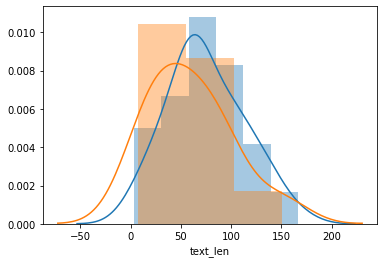

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(df_pred[(df_pred['label']==1)&(df_pred['pred']==1)]['text_len'])
sns.distplot(df_pred[(df_pred['label']==1)&(df_pred['pred']==0)]['text_len'])
plt.show()

In [0]:
er = df_pred[(df_pred['label']==1)&(df_pred['pred']==0)].head(100).reset_index(drop=True)

In [0]:
er['question_tok'] = er['question'].apply(lambda x:tokenizer.tokenize(x))
er['text_tok'] = er['text'].apply(lambda x:tokenizer.tokenize(x))

In [0]:
er.head()

,question,text,label,pred,text_len,question_tok,text_tok
0,Bettoven viết bản sonat ánh trăng để tặng cho ai,Ludwig van Beethoven viết bản sonata này dành ...,1,0,64,"[Bet, ##tov, ##en, viết, bản, sona, ##t, ánh, ...","[Ludwig, van, Beethoven, viết, bản, sona, ##ta..."
1,Biểu tượng của Canada,Cô và Kevin Reynolds là cả hai biểu tượng trượ...,1,0,12,"[Bi, ##ểu, tượng, của, Canada]","[Cô, và, Kevin, Reynolds, là, cả, hai, biểu, t..."
2,"Ấp Hà Đông, tiền thân của làng hoa đầu tiên ở ...",Diện tích đất khai phá ban đầu ở Ấp Hà Đông ch...,1,0,100,"[Ấ, ##p, Hà, Đông, ,, tiền, thân, của, làng, h...","[Di, ##ện, tích, đất, khai, phá, ban, đầu, ở, ..."
3,Thành phố nào là thủ đô của Ba Lan,Vác-sa-va là thủ đô của Ba Lan,1,0,7,"[Thành, phố, nào, là, thủ, đô, của, Ba, Lan]","[V, ##ác, -, sa, -, va, là, thủ, đô, của, Ba, ..."
4,Pháp tấn công xâm lược Việt Nam vào ngày tháng...,"Năm 1958, thực dân Pháp nổ súng tấn công bán đ...",1,0,51,"[Pháp, tấn, công, xâm, lược, Việt, Nam, vào, n...","[Năm, 1958, ,, thực, dân, Pháp, nổ, súng, tấn,..."


In [0]:
for i in range(0,len(er)):
  print('question: %s\nanswer: %s\nprediction:%s\nquestion_tok: %s\ntext_tok: %s\n' % (er.loc[i]['question'],er.loc[i]['text'],er.loc[i]['pred'],er.loc[i]['question_tok'],er.loc[i]['text_tok']))


question: Bettoven viết bản sonat ánh trăng để tặng cho ai
answer: Ludwig van Beethoven viết bản sonata này dành cho cô học sinh dương cầm 17 tuổi của ông Gräfin Giulietta Guicciardi (1784–1856) vào năm 1801 và sau khi ông mất vài năm thì bản sonate được nhà phê bình âm nhạc Ludwig Rellstab đặt cho cái tên phổ biến như bây giờ, ông đã so sánh bản nhạc với ánh trăng trên hồ Lucerne.
prediction:0
question_tok: ['Bet', '##tov', '##en', 'viết', 'bản', 'sona', '##t', 'ánh', 'tr', '##ăng', 'để', 'tặng', 'cho', 'ai']
text_tok: ['Ludwig', 'van', 'Beethoven', 'viết', 'bản', 'sona', '##ta', 'này', 'dành', 'cho', 'cô', 'học', 'sinh', 'dương', 'cầm', '17', 'tuổi', 'của', 'ông', 'Gräfin', 'G', '##iul', '##iet', '##ta', 'G', '##ui', '##ccia', '##rdi', '(', '1784', '[UNK]', '1856', ')', 'vào', 'năm', '1801', 'và', 'sau', 'khi', 'ông', 'mất', 'vài', 'năm', 'thì', 'bản', 'sona', '##te', 'được', 'nhà', 'phê', 'bình', 'âm', 'nhạc', 'Ludwig', 'Re', '##lls', '##tab', 'đặt', 'cho', 'cái', 'tên', 'phổ', 'biế

In [0]:
test_dict = download('https://dl.challenge.zalo.ai/ZAC2019_VietnameseWikiQA/test.zip','test')

262144/257843 [==============================] - 1s 2us/step


In [0]:
from pandas.io.json import json_normalize
test = json_normalize(test_dict,'paragraphs',['__id__','question','title'])

In [0]:
test_InputExamples = test.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['question'], 
                                                                   text_b = x['text'], 
                                                                   label = 0), axis = 1)

In [0]:
df_test = model_predict(estimator_from_tfhub, test_InputExamples)

INFO:tensorflow:Writing example 0 of 2678


INFO:tensorflow:Writing example 0 of 2678


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] To ##à nhà nào cao nhất Việt Nam [SEP] The Landmark 81 là một to ##à nhà ch ##ọc trời trong tổ hợp dự án Vi ##nho ##mes Tân C ##ảng , một dự án có tổng mức đầu tư 40 . 000 tỷ đồng , do Công ty Cổ phần Đầu tư xây dựng Tân Liên Ph ##át thuộc Vi ##ng ##rou ##p làm chủ đầu tư . To ##à tháp cao 81 tầng , hiện tại là to ##à nhà cao nhất Việt Nam và là to ##à nhà cao nhất Đông Nam Á từ tháng 3 năm 2018 . [SEP]


INFO:tensorflow:tokens: [CLS] To ##à nhà nào cao nhất Việt Nam [SEP] The Landmark 81 là một to ##à nhà ch ##ọc trời trong tổ hợp dự án Vi ##nho ##mes Tân C ##ảng , một dự án có tổng mức đầu tư 40 . 000 tỷ đồng , do Công ty Cổ phần Đầu tư xây dựng Tân Liên Ph ##át thuộc Vi ##ng ##rou ##p làm chủ đầu tư . To ##à tháp cao 81 tầng , hiện tại là to ##à nhà cao nhất Việt Nam và là to ##à nhà cao nhất Đông Nam Á từ tháng 3 năm 2018 . [SEP]


INFO:tensorflow:input_ids: 101 11469 10816 13265 27258 15341 13346 14426 12645 102 10117 106969 12324 10331 10417 10114 10816 13265 18643 51025 68121 10504 21217 16117 24467 15832 31826 47877 13546 29199 140 47129 117 10417 24467 15832 10601 23258 46417 11201 24257 10533 119 10259 34096 15049 117 10149 21498 26864 55559 15958 102619 24257 27465 26661 29199 22447 29343 11969 12005 31826 10376 20217 10410 12984 16549 11201 24257 119 11469 10816 86723 15341 12324 61521 117 13526 12086 10331 10114 10816 13265 15341 13346 14426 12645 10432 10331 10114 10816 13265 15341 13346 20053 12645 226 11840 11642 124 10558 10434 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 11469 10816 13265 27258 15341 13346 14426 12645 102 10117 106969 12324 10331 10417 10114 10816 13265 18643 51025 68121 10504 21217 16117 24467 15832 31826 47877 13546 29199 140 47129 117 10417 24467 15832 10601 23258 46417 11201 24257 10533 119 10259 34096 15049 117 10149 21498 26864 55559 15958 102619 24257 27465 26661 29199 22447 29343 11969 12005 31826 10376 20217 10410 12984 16549 11201 24257 119 11469 10816 86723 15341 12324 61521 117 13526 12086 10331 10114 10816 13265 15341 13346 14426 12645 10432 10331 10114 10816 13265 15341 13346 20053 12645 226 11840 11642 124 10558 10434 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] To ##à nhà nào cao nhất Việt Nam [SEP] To ##à tháp cao 81 tầng , hiện tại là to ##à nhà cao nhất Việt Nam và là to ##à nhà cao nhất Đông Nam Á từ tháng 3 năm 2018 . D ##ự án được xây dựng ở Tân C ##ảng , quận Bình Th ##ạnh , ven sông Sài Gòn . D ##ự án được khởi công ngày 26 / 07 / 2014 . [SEP]


INFO:tensorflow:tokens: [CLS] To ##à nhà nào cao nhất Việt Nam [SEP] To ##à tháp cao 81 tầng , hiện tại là to ##à nhà cao nhất Việt Nam và là to ##à nhà cao nhất Đông Nam Á từ tháng 3 năm 2018 . D ##ự án được xây dựng ở Tân C ##ảng , quận Bình Th ##ạnh , ven sông Sài Gòn . D ##ự án được khởi công ngày 26 / 07 / 2014 . [SEP]


INFO:tensorflow:input_ids: 101 11469 10816 13265 27258 15341 13346 14426 12645 102 11469 10816 86723 15341 12324 61521 117 13526 12086 10331 10114 10816 13265 15341 13346 14426 12645 10432 10331 10114 10816 13265 15341 13346 20053 12645 226 11840 11642 124 10558 10434 119 141 42397 15832 10476 27465 26661 1682 29199 140 47129 117 22783 23679 51635 55572 117 26044 23546 97879 104975 119 141 42397 15832 10476 50376 12319 12137 10314 120 10878 120 10194 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 11469 10816 13265 27258 15341 13346 14426 12645 102 11469 10816 86723 15341 12324 61521 117 13526 12086 10331 10114 10816 13265 15341 13346 14426 12645 10432 10331 10114 10816 13265 15341 13346 20053 12645 226 11840 11642 124 10558 10434 119 141 42397 15832 10476 27465 26661 1682 29199 140 47129 117 22783 23679 51635 55572 117 26044 23546 97879 104975 119 141 42397 15832 10476 50376 12319 12137 10314 120 10878 120 10194 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Messi thuận chân nào [SEP] Đô ##i chân ngắn nhưng mạnh m ##ẽ giúp Messi dễ dà ##ng tăng tốc và s ##ải chân nhanh giúp anh kiểm soát bóng tốt khi r ##ê d ##ắt ở tốc độ cao . C ##ựu huấn luyện viên Barcelona , Pe ##p Guard ##iola , từng nhận xét rằng : " Messi là cầu thủ duy nhất chạy với bóng còn nhanh hơn là chạy không bóng . " G ##i ##ống Mara ##dona , Messi là một cầu thủ thuận chân trái . [SEP]


INFO:tensorflow:tokens: [CLS] Messi thuận chân nào [SEP] Đô ##i chân ngắn nhưng mạnh m ##ẽ giúp Messi dễ dà ##ng tăng tốc và s ##ải chân nhanh giúp anh kiểm soát bóng tốt khi r ##ê d ##ắt ở tốc độ cao . C ##ựu huấn luyện viên Barcelona , Pe ##p Guard ##iola , từng nhận xét rằng : " Messi là cầu thủ duy nhất chạy với bóng còn nhanh hơn là chạy không bóng . " G ##i ##ống Mara ##dona , Messi là một cầu thủ thuận chân trái . [SEP]


INFO:tensorflow:input_ids: 101 94280 58629 28066 27258 102 37412 10116 28066 51656 15662 29172 181 45563 31487 94280 58160 55962 10376 21740 43978 10432 187 32123 28066 41652 31487 19087 43229 64520 22270 33598 12072 186 15915 172 67188 1682 43978 14776 15341 119 140 71629 72170 52320 15202 12113 117 29005 10410 28739 63005 117 26258 16638 66331 16487 131 107 94280 10331 19168 18755 38779 13346 38135 11182 22270 14674 41652 14789 10331 38135 11755 22270 119 107 144 10116 29028 48690 64674 117 94280 10331 10417 19168 18755 58629 28066 57469 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 94280 58629 28066 27258 102 37412 10116 28066 51656 15662 29172 181 45563 31487 94280 58160 55962 10376 21740 43978 10432 187 32123 28066 41652 31487 19087 43229 64520 22270 33598 12072 186 15915 172 67188 1682 43978 14776 15341 119 140 71629 72170 52320 15202 12113 117 29005 10410 28739 63005 117 26258 16638 66331 16487 131 107 94280 10331 19168 18755 38779 13346 38135 11182 22270 14674 41652 14789 10331 38135 11755 22270 119 107 144 10116 29028 48690 64674 117 94280 10331 10417 19168 18755 58629 28066 57469 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Messi thuận chân nào [SEP] C ##ựu huấn luyện viên Barcelona , Pe ##p Guard ##iola , từng nhận xét rằng : " Messi là cầu thủ duy nhất chạy với bóng còn nhanh hơn là chạy không bóng . " G ##i ##ống Mara ##dona , Messi là một cầu thủ thuận chân trái . Anh thường sử dụng má ngoài chân trái khi giữ bóng , trong khi dùng má trong để d ##ứt điểm , chu ##yền bóng và kiến tạo cho đồng đội . [SEP]


INFO:tensorflow:tokens: [CLS] Messi thuận chân nào [SEP] C ##ựu huấn luyện viên Barcelona , Pe ##p Guard ##iola , từng nhận xét rằng : " Messi là cầu thủ duy nhất chạy với bóng còn nhanh hơn là chạy không bóng . " G ##i ##ống Mara ##dona , Messi là một cầu thủ thuận chân trái . Anh thường sử dụng má ngoài chân trái khi giữ bóng , trong khi dùng má trong để d ##ứt điểm , chu ##yền bóng và kiến tạo cho đồng đội . [SEP]


INFO:tensorflow:input_ids: 101 94280 58629 28066 27258 102 140 71629 72170 52320 15202 12113 117 29005 10410 28739 63005 117 26258 16638 66331 16487 131 107 94280 10331 19168 18755 38779 13346 38135 11182 22270 14674 41652 14789 10331 38135 11755 22270 119 107 144 10116 29028 48690 64674 117 94280 10331 10417 19168 18755 58629 28066 57469 119 15212 16591 14808 15237 13267 25331 28066 57469 12072 25618 22270 117 10504 12072 22344 13267 10504 12460 172 76290 15509 117 109628 96097 22270 10432 32051 17783 11257 15049 15671 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 94280 58629 28066 27258 102 140 71629 72170 52320 15202 12113 117 29005 10410 28739 63005 117 26258 16638 66331 16487 131 107 94280 10331 19168 18755 38779 13346 38135 11182 22270 14674 41652 14789 10331 38135 11755 22270 119 107 144 10116 29028 48690 64674 117 94280 10331 10417 19168 18755 58629 28066 57469 119 15212 16591 14808 15237 13267 25331 28066 57469 12072 25618 22270 117 10504 12072 22344 13267 10504 12460 172 76290 15509 117 109628 96097 22270 10432 32051 17783 11257 15049 15671 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] Messi thuận chân nào [SEP] Ngoài ra anh còn một chân sú ##t ph ##ạt chính và hay đảm nhận các quả ph ##ạt đền của đội . Khi đề cập đến k ##ĩ năng d ##ắt bóng của anh , Mara ##dona đã từng nói : " Trái bóng d ##ính ch ##ặt vào chân anh ấy ; Trong sự nghiệp của mình tôi đã xem nhiều cầu thủ xuất chúng chơi bóng nhưng không ai giữ bóng tốt như Messi . " Mara ##dona còn cho biết rằng ông tin Messi là cầu thủ xuất sắc nhất thế giới hiện tại . [SEP]


INFO:tensorflow:tokens: [CLS] Messi thuận chân nào [SEP] Ngoài ra anh còn một chân sú ##t ph ##ạt chính và hay đảm nhận các quả ph ##ạt đền của đội . Khi đề cập đến k ##ĩ năng d ##ắt bóng của anh , Mara ##dona đã từng nói : " Trái bóng d ##ính ch ##ặt vào chân anh ấy ; Trong sự nghiệp của mình tôi đã xem nhiều cầu thủ xuất chúng chơi bóng nhưng không ai giữ bóng tốt như Messi . " Mara ##dona còn cho biết rằng ông tin Messi là cầu thủ xuất sắc nhất thế giới hiện tại . [SEP]


INFO:tensorflow:input_ids: 101 94280 58629 28066 27258 102 45447 11859 19087 14674 10417 28066 17024 10123 99142 29882 12707 10432 13605 62787 16638 10792 25308 99142 29882 97001 10447 15671 119 30306 20192 41472 12002 179 74016 20046 172 67188 22270 10447 19087 117 48690 64674 11213 26258 22072 131 107 82051 22270 172 59304 18643 77381 11603 28066 19087 52256 132 16461 12636 20608 10447 17830 40813 11213 35143 13710 19168 18755 14930 18097 25357 22270 15662 11755 11346 25618 22270 33598 12552 94280 119 107 48690 64674 14674 11257 21820 16487 12660 21629 94280 10331 19168 18755 14930 31137 13346 14421 15814 13526 12086 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 94280 58629 28066 27258 102 45447 11859 19087 14674 10417 28066 17024 10123 99142 29882 12707 10432 13605 62787 16638 10792 25308 99142 29882 97001 10447 15671 119 30306 20192 41472 12002 179 74016 20046 172 67188 22270 10447 19087 117 48690 64674 11213 26258 22072 131 107 82051 22270 172 59304 18643 77381 11603 28066 19087 52256 132 16461 12636 20608 10447 17830 40813 11213 35143 13710 19168 18755 14930 18097 25357 22270 15662 11755 11346 25618 22270 33598 12552 94280 119 107 48690 64674 14674 11257 21820 16487 12660 21629 94280 10331 19168 18755 14930 31137 13346 14421 15814 13526 12086 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 256)


INFO:tensorflow:  name = input_ids, shape = (1, 256)


INFO:tensorflow:  name = input_mask, shape = (1, 256)


INFO:tensorflow:  name = input_mask, shape = (1, 256)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 256)


INFO:tensorflow:  name = segment_ids, shape = (1, 256)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:Restoring parameters from gs://bert-logs-zalo/bert-tfhub/models/WikiQAv5.0/model.ckpt-3361


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 5 seconds


INFO:tensorflow:Initialized TPU in 5 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


In [0]:
len(test)

2678

In [0]:
df_sub = pd.merge(test,df_test,left_index=True,right_index=True)

In [0]:
df_final = df_sub[df_sub['pred']==1][['__id__','id']].reset_index(drop=True)

In [0]:
df_final = df_final.rename(columns={'id':'answer','__id__':'test_id'})

In [0]:
df_final.to_csv('submission_5.csv',index=False)